#                            Billionaires Statistics Dataset (2023)

## Introduction

This dataset contains statistics on the world's billionaires, including information about their businesses, industries, and personal details. It provides insights into the wealth distribution, business sectors, and demographics of billionaires worldwide.

### Variable Description

rank: The ranking of the billionaire in terms of wealth.

finalWorth: The final net worth of the billionaire in U.S. dollars.

category: The category or industry in which the billionaire's business operates.

personName: The full name of the billionaire.

age: The age of the billionaire.

country: The country in which the billionaire resides.

city: The city in which the billionaire resides.

source: The source of the billionaire's wealth.

industries: The industries associated with the billionaire's business interests.

countryOfCitizenship: The country of citizenship of the billionaire.

organization: The name of the organization or company associated with the billionaire.

selfMade: Indicates whether the billionaire is self-made (True/False).

status: "D" represents self-made billionaires (Founders/Entrepreneurs) and "U" indicates inherited or unearned wealth.

gender: The gender of the billionaire.

birthDate: The birthdate of the billionaire.

lastName: The last name of the billionaire.

firstName: The first name of the billionaire.

title: The title or honorific of the billionaire.

date: The date of data collection.

state: The state in which the billionaire resides.

residenceStateRegion: The region or state of residence of the billionaire.

birthYear: The birth year of the billionaire.

birthMonth: The birth month of the billionaire.

birthDay: The birth day of the billionaire.

cpi_country: Consumer Price Index (CPI) for the billionaire's country.

cpi_change_country: CPI change for the billionaire's country.

gdp_country: Gross Domestic Product (GDP) for the billionaire's country.

gross_tertiary_education_enrollment: Enrollment in tertiary education in the billionaire's country.

gross_primary_education_enrollment_country: Enrollment in primary education in the billionaire's country.

life_expectancy_country: Life expectancy in the billionaire's country.

tax_revenue_country_country: Tax revenue in the billionaire's country.

total_tax_rate_country: Total tax rate in the billionaire's country.

population_country: Population of the billionaire's country.

latitude_country: Latitude coordinate of the billionaire's country.

longitude_country: Longitude coordinate of the billionaire's country.

### Potential Use Cases

Wealth distribution analysis: Explore the distribution of billionaires' wealth across different industries, countries, and based on gender.

Self-made vs. inherited wealth: Analyze the proportion of self-made billionaires and those who inherited their wealth.
    
Demographic analysis: Investigate the age, gender, and birthplace demographics of billionaires.
    
Economic indicators: Study correlations between billionaire wealth and economic indicators such as GDP, CPI, and tax rates.
    
Geospatial analysis: Visualize the geographical distribution of billionaires and their wealth on a map.
    
Trends over time: Track changes in billionaire demographics and wealth over the years.

In [32]:
#!pip install xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,  LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from xgboost import XGBClassifier

In [33]:
import sqlite3
conn = sqlite3.connect('billionaires.db')
cur = conn.cursor()
cur.execute('''DROP TABLE IF EXISTS export''')
conn.commit()

from sqlite3 import Error
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

### Parsing the CSV file

In [34]:
#loop through each char and check if the char is within quotes. If not, it's a delimiter and further split on it. 
def custom_csv_split(line):
    values = []
    in_quotes = False
    current_value = ""

    for char in line:
        if char == '"':
            in_quotes = not in_quotes
        elif char == ',' and not in_quotes:
            values.append(current_value)
            current_value = ""
        else:
            current_value += char

    values.append(current_value)
    return values

billionaires_data = []

with open('billionaires_data.csv', 'r') as file:
    lines = file.readlines()
    header = custom_csv_split(lines[0])
    
    for line in lines[1:]:
        values = custom_csv_split(line)
        row = {header[i]: values[i] for i in range(len(header))}
        billionaires_data.append(row)


## Normalization
### Create Industry table

In [35]:
cur.execute("DROP TABLE IF EXISTS Industry;")

create_table_industries_sql = """CREATE TABLE IF NOT EXISTS Industry (
            industry_id INTEGER PRIMARY KEY AUTOINCREMENT,
            industries TEXT,
            source TEXT
        );
"""

# Create the Industries table
create_table(conn, create_table_industries_sql)

# Insert data into the Industries table
cursor = conn.cursor()
for row in billionaires_data:
    industries = row.get('industries', '').strip('"\n').strip()
    source = row.get('source', '').strip('"\n').strip()  # Assuming 'source' is the column name

    if industries and not any(char.isdigit() for char in industries):
        cursor.execute('''
            INSERT INTO Industry (industries, source)
            VALUES (?, ?)
        ''', (industries, source))

conn.commit()
sql_statement = "Select * from Industry"
df = pd.read_sql_query(sql_statement, conn)
display(df) 

,industry_id,industries,source
0,1,Fashion & Retail,LVMH
1,2,Automotive,"Tesla, SpaceX"
2,3,Technology,Amazon
3,4,Technology,Oracle
4,5,Finance & Investments,Berkshire Hathaway
...,...,...,...
2635,2636,Healthcare,Health clinics
2636,2637,Food & Beverage,Beer
2637,2638,Manufacturing,Tyre manufacturing machinery
2638,2639,Real Estate,Real estate


### Create the Countries table

In [36]:
cur.execute("DROP TABLE IF EXISTS Countries;")

create_table_country_sql = """CREATE TABLE IF NOT EXISTS Countries (
    country_id INTEGER PRIMARY KEY AUTOINCREMENT,
    country TEXT,
    city TEXT,
    cpi_country REAL,
    cpi_change_country REAL,
    gdp_country REAL,
    life_expectancy_country REAL,
    tax_revenue_country REAL,
    total_tax_rate_country REAL,
    population_country INTEGER,
    latitude_country REAL,
    longitude_country REAL
);
"""

create_table(conn, create_table_country_sql)

# Insert data into the Country table
cursor = conn.cursor()
for row in billionaires_data:
    # Replace blank data with NULL for all columns
    values = {
        'country': None if row.get('country', '') == '' else row.get('country', ''),
        'city': None if row.get('city', '') == '' else row.get('city', ''),
        'cpi_country': None if row.get('cpi_country', '') == '' else row.get('cpi_country', ''),
        'cpi_change_country': None if row.get('cpi_change_country', '') == '' else row.get('cpi_change_country', ''),
        'gdp_country': None if row.get('gdp_country', '') == '' else row.get('gdp_country', '').strip('"\n').strip(),
        'life_expectancy_country': None if row.get('life_expectancy_country', '') == '' else row.get('life_expectancy_country', '').strip('"\n').strip(),
        'tax_revenue_country': None if row.get('tax_revenue_country', '') == '' else row.get('tax_revenue_country', ''),
        'total_tax_rate_country': None if row.get('total_tax_rate_country', '') == '' else row.get('total_tax_rate_country', '').strip('"\n').strip(),
        'population_country': None if row.get('population_country', '') == '' else row.get('population_country', ''),
        'latitude_country': None if row.get('latitude_country', '') == '' else row.get('latitude_country', ''),
        'longitude_country': None if row.get('longitude_country', '') == '' else row.get('longitude_country', '')
    }

    cursor.execute('''
        INSERT INTO Countries (country, city, cpi_country, cpi_change_country, gdp_country,
                            life_expectancy_country, tax_revenue_country, total_tax_rate_country,
                            population_country, latitude_country, longitude_country)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        values['country'], values['city'], values['cpi_country'],
        values['cpi_change_country'], values['gdp_country'],
        values['life_expectancy_country'], values['tax_revenue_country'],
        values['total_tax_rate_country'], values['population_country'],
        values['latitude_country'], values['longitude_country']
    ))

conn.commit()

# Query and display the Country table
sql_statement_country = "SELECT * FROM Countries"
df_country = pd.read_sql_query(sql_statement_country, conn)
display(df_country)


,country_id,country,city,cpi_country,cpi_change_country,gdp_country,life_expectancy_country,tax_revenue_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,France,Paris,110.05,1.1,"$2,715,518,274,227",82.5,None,60.7,6.705989e+07,46.227638,None
1,2,United States,Austin,117.24,7.5,"$21,427,700,000,000",78.5,None,36.6,3.282395e+08,37.090240,None
2,3,United States,Medina,117.24,7.5,"$21,427,700,000,000",78.5,None,36.6,3.282395e+08,37.090240,None
3,4,United States,Lanai,117.24,7.5,"$21,427,700,000,000",78.5,None,36.6,3.282395e+08,37.090240,None
4,5,United States,Omaha,117.24,7.5,"$21,427,700,000,000",78.5,None,36.6,3.282395e+08,37.090240,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2635,2636,China,Shanghai,125.08,2.9,"$19,910,000,000,000",77.0,None,59.2,1.397715e+09,35.861660,None
2636,2637,United States,Pottsville,117.24,7.5,"$21,427,700,000,000",78.5,None,36.6,3.282395e+08,37.090240,None
2637,2638,China,Gaomi,125.08,2.9,"$19,910,000,000,000",77.0,None,59.2,1.397715e+09,35.861660,None
2638,2639,China,Nanjing,125.08,2.9,"$19,910,000,000,000",77.0,None,59.2,1.397715e+09,35.861660,None


### Create Billionaires table

In [37]:
cur.execute("DROP TABLE IF EXISTS Billionaires;")
create_table_sql = """CREATE TABLE IF NOT EXISTS Billionaires (
            Billionaire_id INTEGER PRIMARY KEY AUTOINCREMENT,
            
            Rank INTEGER,
            personName TEXT NOT NULL,
            finalWorth REAL,
            age INTEGER,
            country TEXT,
            industries TEXT,
            selfMade TEXT,
            gender TEXT,
            FOREIGN KEY(Billionaire_id) REFERENCES Countries(country_id),
            FOREIGN KEY(Billionaire_id) REFERENCES Industry(industry_id)
        );
  """
create_table(conn, create_table_sql)
def insert_billionaires_data(conn, data):

    cursor = conn.cursor()
    for row in data:
        cursor.execute('''
            INSERT INTO Billionaires (Rank, personName, finalWorth, age, country, industries, selfMade, gender)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            row.get('rank', ''),
            row.get('personName', ''),
            row.get('finalWorth', 0),
            row.get('age', 0),
            row.get('country', ''),
            row.get('industries', ''),
            row.get('selfMade', ''),
            row.get('gender', '')
        ))
    conn.commit()

insert_billionaires_data(conn, billionaires_data)
sql_statement = "Select * from Billionaires"
df = pd.read_sql_query(sql_statement, conn)
display(df) 

,Billionaire_id,Rank,personName,finalWorth,age,country,industries,selfMade,gender
0,1,,Bernard Arnault & family,211000.0,74,France,Fashion & Retail,FALSE,M
1,2,,Elon Musk,180000.0,51,United States,Automotive,TRUE,M
2,3,,Jeff Bezos,114000.0,59,United States,Technology,TRUE,M
3,4,,Larry Ellison,107000.0,78,United States,Technology,TRUE,M
4,5,,Warren Buffett,106000.0,92,United States,Finance & Investments,TRUE,M
...,...,...,...,...,...,...,...,...,...
2635,2636,,Yu Rong,1000.0,51,China,Healthcare,TRUE,M
2636,2637,,Richard Yuengling Jr.,1000.0,80,United States,Food & Beverage,FALSE,M
2637,2638,,Zhang Gongyun,1000.0,60,China,Manufacturing,TRUE,M
2638,2639,,Zhang Guiping & family,1000.0,71,China,Real Estate,TRUE,M


### SQL join statements to retrieve data into Pandas for analysis.

In [38]:
sql_query = '''
    SELECT
        Billionaires.Billionaire_id,
        Billionaires.personName,
        Billionaires.finalWorth,
        Billionaires.age,
        Billionaires.selfMade,
        Billionaires.gender,
        Countries.country,
        Industry.industries
        
    FROM
        Billionaires
    JOIN
        Countries ON Billionaires.Billionaire_id = Countries.country_id
    JOIN
        industry ON Billionaires.Billionaire_id = Industry.industry_id
'''

# Execute the SQL query and fetch results into a Pandas DataFrame
df = pd.read_sql_query(sql_query, conn)

# Close the database connection
conn.close()

# Display the DataFrame
df.head()

,Billionaire_id,personName,finalWorth,age,selfMade,gender,country,industries
0,1,Bernard Arnault & family,211000.0,74,FALSE,M,France,Fashion & Retail
1,2,Elon Musk,180000.0,51,TRUE,M,United States,Automotive
2,3,Jeff Bezos,114000.0,59,TRUE,M,United States,Technology
3,4,Larry Ellison,107000.0,78,TRUE,M,United States,Technology
4,5,Warren Buffett,106000.0,92,TRUE,M,United States,Finance & Investments


### Data Overview

In [39]:
df.shape

(2640, 8)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Billionaire_id  2640 non-null   int64  
 1   personName      2640 non-null   object 
 2   finalWorth      2640 non-null   float64
 3   age             2640 non-null   object 
 4   selfMade        2640 non-null   object 
 5   gender          2640 non-null   object 
 6   country         2602 non-null   object 
 7   industries      2640 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 165.1+ KB


In [41]:
df.isnull().sum()

Billionaire_id     0
personName         0
finalWorth         0
age                0
selfMade           0
gender             0
country           38
industries         0
dtype: int64

In [42]:
# Drop rows with missing values
df = df.dropna()

In [43]:
df["finalWorth"].describe()

count      2602.000000
mean       4655.995388
std        9897.776858
min        1000.000000
25%        1500.000000
50%        2300.000000
75%        4300.000000
max      211000.000000
Name: finalWorth, dtype: float64

describe() shows the statistics of numerical variables 
## Exploratory Data Analysis

<Axes: xlabel='finalWorth', ylabel='Count'>

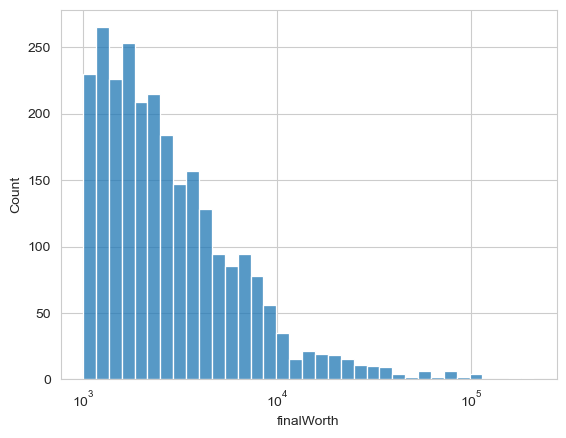

In [44]:
# Net Worth Insights
sns.histplot(df, x='finalWorth', log_scale=True)

In [45]:
round((df[df['finalWorth'] < 10000].shape[0] / df.shape[0]) * 100, 2)

93.04

#### 93% of billionaires have a net worth less than 10,000 (10 Billion US Dollars).

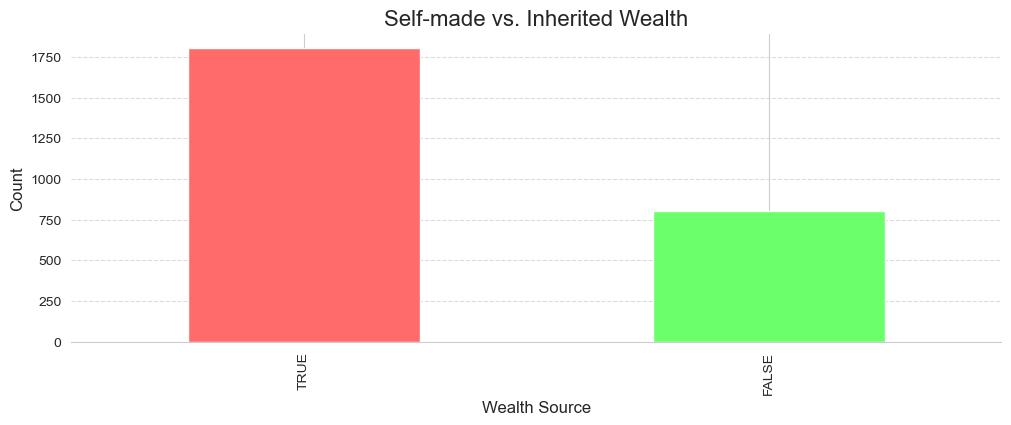

In [46]:
colors = ['#FF6B6B', '#6BFF6B']

plt.figure(figsize=(12, 4))
df['selfMade'].value_counts().plot(kind='bar', color=colors)
plt.title('Self-made vs. Inherited Wealth', fontsize=16)
plt.xlabel('Wealth Source', fontsize=12)
plt.ylabel('Count', fontsize=12)

sns.set_style("whitegrid")
sns.despine(left=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [47]:
df["selfMade"].unique()

array(['FALSE', 'TRUE'], dtype=object)

In [48]:
df["country"].unique()

array(['France', 'United States', 'Mexico', 'India', 'Spain', 'China',
       'Canada', 'Germany', 'Switzerland', 'Belgium', 'Hong Kong',
       'Austria', 'Japan', 'United Kingdom', 'Australia', 'Indonesia',
       'United Arab Emirates', 'Russia', 'Chile', 'Monaco',
       'Czech Republic', 'Sweden', 'Thailand', 'Uzbekistan', 'Singapore',
       'Nigeria', 'Israel', 'Italy', 'South Africa', 'Brazil', 'Malaysia',
       'South Korea', 'New Zealand', 'Philippines', 'Taiwan', 'Norway',
       'Egypt', 'Denmark', 'Eswatini (Swaziland)', 'Colombia',
       'Netherlands', 'Poland', 'Bahamas', 'Ukraine', 'Cayman Islands',
       'Greece', 'Turkey', 'Argentina', 'Georgia', 'Portugal',
       'Kazakhstan', 'Algeria', 'Vietnam', 'Latvia', 'Finland', 'Bermuda',
       'Luxembourg', 'British Virgin Islands', 'Cambodia', 'Lebanon',
       'Oman', 'Ireland', 'Cyprus', 'Guernsey', 'Liechtenstein',
       'Turks and Caicos Islands', 'Romania', 'Qatar', 'Uruguay', 'Nepal',
       'Slovakia', 'Morocco

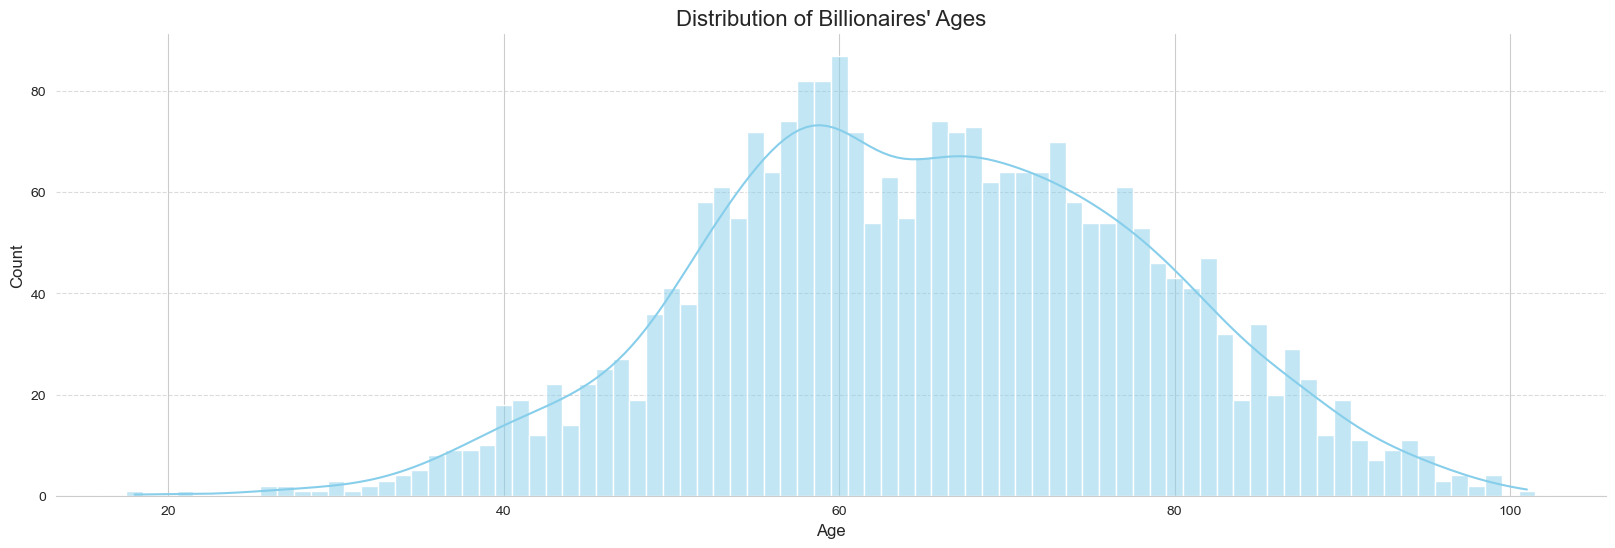

In [49]:
plt.figure(figsize=(20, 6))
sns.histplot(data=df[df['age'].notnull()], x='age', bins=30, color='skyblue', kde=True)
plt.title('Distribution of Billionaires\' Ages', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)

sns.set_style("whitegrid")
sns.despine(left=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

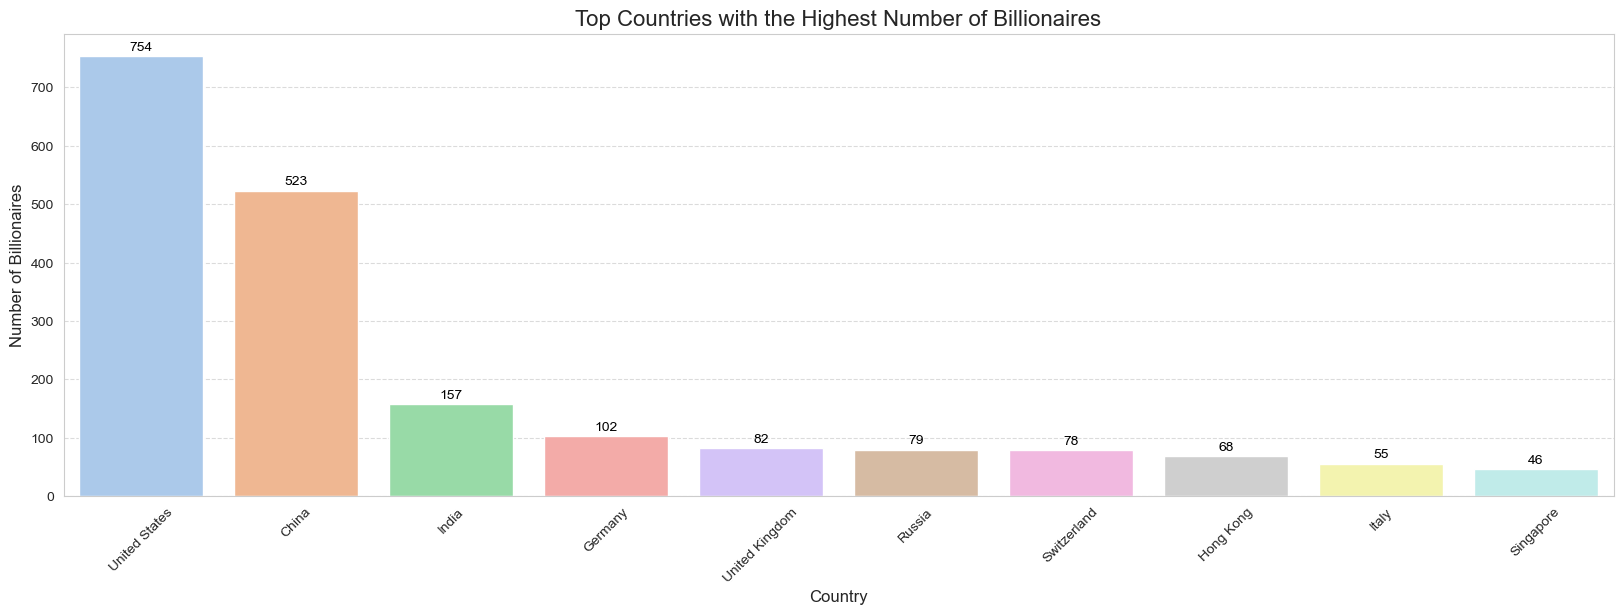

In [50]:
top_countries =  df['country'].value_counts().head(10)

colors = sns.color_palette("pastel")

plt.figure(figsize=(20, 6))
sns.barplot(x=top_countries.index, y=top_countries, palette=colors)
plt.title('Top Countries with the Highest Number of Billionaires', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Billionaires', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top_countries):
    plt.text(i, v + 5, str(v), color='black', ha='center', va='bottom', fontsize=10)

plt.show()

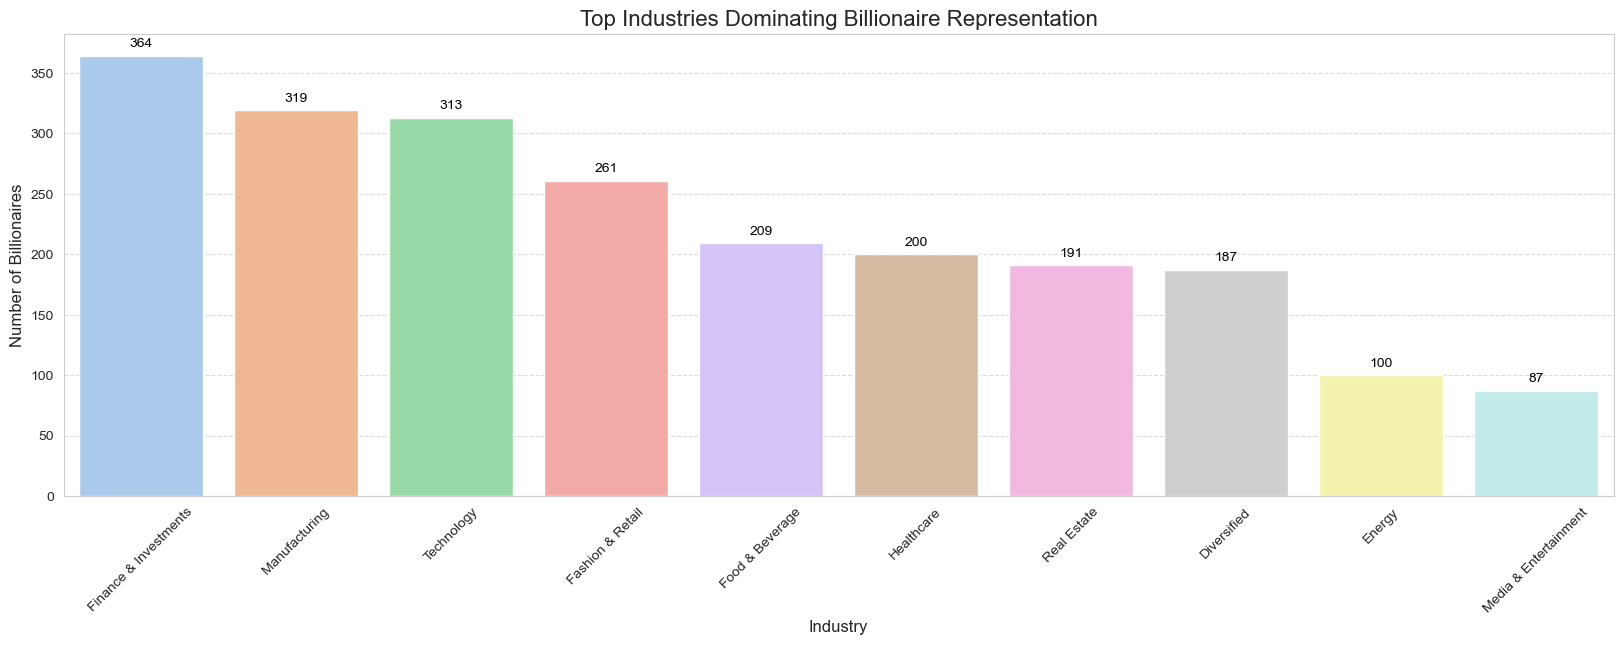

In [51]:
top_industries = df['industries'].value_counts().head(10)

plt.figure(figsize=(20, 6))
sns.barplot(x=df['industries'].value_counts().head(10).index, y=top_industries, palette=colors)
plt.title('Top Industries Dominating Billionaire Representation', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Billionaires', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top_industries):
    plt.text(i, v + 5, str(v), color='black', ha='center', va='bottom', fontsize=10)

plt.show()

<Axes: ylabel='gender'>

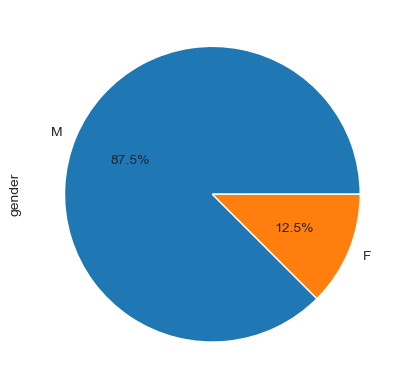

In [52]:
# Visualizing gender distribution
df['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [53]:
df.groupby('gender', as_index=False)['finalWorth'].mean()

,gender,finalWorth
0,F,4627.384615
1,M,4660.079051


### Hypothesis Testing
### Is there a significant difference between the net worth of male and female billionaires?
### Ho = No difference in net worth
### H1 = Difference in net worth

In [54]:
female_fw = df[df['gender'] == 'F']['finalWorth']
male_fw = df[df['gender'] == 'M']['finalWorth']
import scipy.stats as stats
t_statistic, p_value = stats.ttest_ind(male_fw, female_fw)

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 0.05569580661275628
P-value: 0.9555884195269275


### As the T value is small and the P value is far greater than 0.05, the conclusion is that there is no statistically significant difference in the final worth of men and women.

In [55]:
df = pd.get_dummies(df, columns=['gender',"country",'industries'], drop_first=True)
df.replace('', np.nan, inplace=True)

# Drop rows with empty strings
df = df.dropna()
# Separate features (X) and target variable (y)
X = df.drop(['selfMade', 'Billionaire_id','personName'], axis=1)  # Drop target and irrelevant columns
y = df['selfMade']

scaler=StandardScaler()
X_pf=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X2, y_train, y2 = train_test_split(X_pf, y, train_size=0.5, shuffle=True, 
                                            stratify=y, random_state=55)

# Create validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, shuffle=True,
                                                stratify=y2, random_state=55)


In [56]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

models = [RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier()]

train_score = []
validation_score = []

for model in models:
    # Use the training data set to develop the model.
    model.fit(X_train, y_train_encoded)
    # Compute statistical values such as f1 score identifying the model development performance.
    y_train_pred = model.predict(X_train)
    train_score.append(f1_score(y_train_encoded, y_train_pred))
    # Calculate the model results to the data points in the validation data set.
    y_val_pred = model.predict(X_val)
    # Compute statistical values comparing the model results to the validation data.
    validation_score.append(f1_score(y_val_encoded, y_val_pred))


In [57]:
import plotly.graph_objects as go
f2=go.Figure()
models= ['RandomForestClassifier', 'GradientBoostingClassifier','XGBClassifier']

f2.add_trace(go.Bar(x=models, y=train_score, name='Train', text=train_score , textposition='outside',
                     texttemplate='%{text:.2f}%', width=0.38, 
                     hovertemplate='accuracy of %{x} = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#AF4343', opacity=0.8)))
f2.add_trace(go.Bar(x=models, y=validation_score, name='validation', text=validation_score, textposition='outside',
                     texttemplate='%{text:.2f}%', width=0.38, 
                     hovertemplate='accuracy of %{x} = %{y:.2f}%<extra></extra>',
                     marker=dict(color='#C6AA97', opacity=0.8)))


temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))
f2.update_traces(marker=dict(line=dict(width=1, color='#000000')))
f2.update_layout(title="Model Comparision", showlegend=True, template=temp, 
                  legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=.97),
                  barmode='group', bargap=.15)
f2.update_yaxes(range=(0,1.1))

### There is overfitting in all models so we will select the RandomForestClassifier. Let's use GridSearchCV to tune hyperparameters.

In [58]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'], 
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Create the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Retrain the best model on the entire training set
best_model.fit(X_train_scaled, y_train)

# Model prediction
y_pred = best_model.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report_str)
print("Confusion Matrix:\n", conf_matrix)


Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

       FALSE       0.75      0.51      0.61       193
        TRUE       0.81      0.93      0.87       445

    accuracy                           0.80       638
   macro avg       0.78      0.72      0.74       638
weighted avg       0.80      0.80      0.79       638

Confusion Matrix:
 [[ 98  95]
 [ 32 413]]


The classification report provides several metrics to evaluate the performance of a classification model. Here's an explanation of the key metrics in the classification report:

### Precision:
Precision is the ratio of correctly predicted positive observations to the total predicted positives.
Precision = True Positives / (True Positives + False Positives)
For the 'TRUE' class:
Precision = 0.82
For the 'FALSE' class:
Precision = 0.74
### Recall (Sensitivity or True Positive Rate):
Recall is the ratio of correctly predicted positive observations to all the actual positives.
Recall = True Positives / (True Positives + False Negatives)
For the 'TRUE' class:
Recall = 0.91
For the 'FALSE' class:
Recall = 0.54
### F1-Score:
The F1-score is the weighted average of precision and recall. It is a balance between precision and recall.
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
For the 'TRUE' class:
F1-Score = 0.86
For the 'FALSE' class:
F1-Score = 0.63
### Support:
Support is the number of actual occurrences of the class in the specified dataset.
For the 'TRUE' class:
Support = 445
For the 'FALSE' class:
Support = 193
### Accuracy:
Accuracy is the ratio of correctly predicted observations to the total observations.
Accuracy = (True Positives + True Negatives) / (Total Observations)
Overall Accuracy = 0.79
### Macro Average and Weighted Average:
Macro average computes the average of metrics for each class without considering class imbalance.
Weighted average considers the class imbalance by weighting each class's metrics by its support.

In summary, our model has achieved an overall accuracy of 0.80 approximately, indicating that it correctly predicted the class for 80% of the observations. The classification report provides a more detailed assessment of the model's performance for each class. The high precision, recall, and F1-score for the 'TRUE' class suggest good performance, while the 'FALSE' class has lower values, indicating room for improvement, especially in recall.

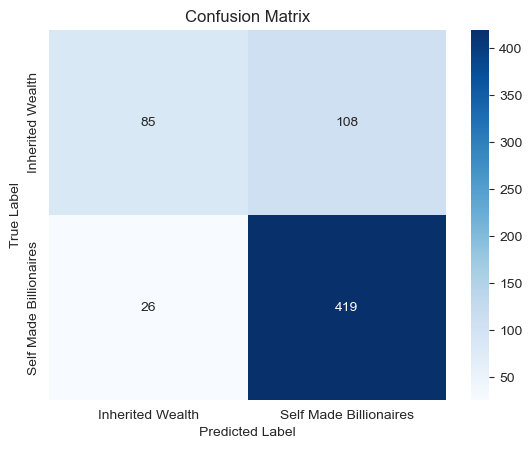

In [29]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Inherited Wealth', 'Self Made Billionaires'], yticklabels=['Inherited Wealth', 'Self Made Billionaires'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### The confusion matrix plot visually represents these four components. Here's how to interpret the plot:

### Top-Left (TP): The top-left cell represents the number of instances where the true class is positive, and the model correctly predicted it as positive.

### Top-Right (FP): The top-right cell represents the number of instances where the true class is negative, but the model incorrectly predicted it as positive.

### Bottom-Left (FN): The bottom-left cell represents the number of instances where the true class is positive, but the model incorrectly predicted it as negative.

### Bottom-Right (TN): The bottom-right cell represents the number of instances where the true class is negative, and the model correctly predicted it as negative.